# Custom Environment: Simple Haunted Mansion
------

## Basic Game Information

For this notebook, I will be simplifying the scope of the environment. In the simple Haunted Mansion, there are no ghosts or candies, the only reward is the exit door.

Below is further information:

    - There are 4 discrete actions the agent can take: up. down, left and right
    - The game terminates when the agent has reached the exit door of the haunted mansion
    - To keep it simple, the agent is only to receive a reward of + 1 when they have reached the exit door
    - The agent represents the trick-or-treater
    

## Set Up
-----

In [1]:
import numpy as np
import gymnasium as gym
#import gym 
import pygame
from simple_env import Simple_Haunted_Mansion
import matplotlib.pyplot as plt

## Defining a Custom Environment
---

OpenAI Gymnasium has some code to help create custom environments, link: https://gymnasium.farama.org/introduction/create_custom_env/

I have used this code as the basis for my custom environment.

In [2]:
# Register the environment
gym.register(
    id='Haunted_Mansion-v1',
    entry_point='simple_env:Simple_Haunted_Mansion'  
)

In [3]:
# Make the custom env, set the render_mode to huamn
env = gym.make('Haunted_Mansion-v1',  render_mode='human')

## Random Movement (Testing of the Rendering)

In [29]:
# Resetting the environment, to set the agent to a random starting place on the grid
env.reset()

# Run the environment for 50 random steps
for i in range(50):

    # Using sample() to pick random action for agent to take
    action = env.action_space.sample()
    # Calling step to get information on env after action takes the random action
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Rendering env to see the agent's movement
    env.render()
    
    # Add time delay in pygame to pause after each action, allows for better viewing
    pygame.time.delay(350)

    # If the agent has reached the target, break out of the loop and end the episode
    if terminated:
        break
        
# Close the environment
env.close()

## Training with PPO Algorithm
----

Deciding not to store logs at the moment as environment is fairly simple.

In [4]:
# Importing stable baselines 3 for PPO and Wrappers
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecMonitor

In [5]:
gym.register(
    id='Haunted_Mansion-v1',
    entry_point='simple_env:Simple_Haunted_Mansion'  
)

/Users/simybasra/anaconda3/envs/trick_or_retreat/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Haunted_Mansion-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [6]:
log_path = ('../../Training/Logs/')

In [7]:
# Create the environment and vectorise it using DummyVecEnv
v_env = DummyVecEnv([lambda: gym.make('Haunted_Mansion-v1', render_mode = None) for i in range(3)])
# Using vec monitor since have multiple environments
learn_env = VecMonitor(v_env,filename=log_path) 


In [8]:
# Initialise PPO model
# Having to use MultiInputPolicy instead of MlpPolicy since observations are of type dict
model = PPO('MultiInputPolicy', learn_env, verbose=1)

# Train the agent for 50_000 time steps
model.learn(total_timesteps=50_000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.4     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 11884    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 6144     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36.1        |
|    ep_rew_mean          | 1           |
| time/                   |             |
|    fps                  | 6207        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.019317197 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.0699      |
|    learning

### Training Logs and Graphs

In [9]:
# Path to monitor.csv file
monitor_file = ('../../Training/Logs/monitor.csv') 

In [10]:
import pandas as pd
# Read the CSV file using pandas
df = pd.read_csv(monitor_file,skiprows=1)

In [11]:
episode_rewards = df['r'].values  # 'r' column contains the reward per episode
episode_lengths = df['l'].values  # 'l' column contains the length of each episode
episode_time = df['t'].values 

In [12]:
# Using moving average to smooth out the noise in both rewards and episode length
smoothed_rewards = pd.Series(episode_rewards).rolling(window=100).mean()
smoothed_length = pd.Series(episode_lengths).rolling(window=100).mean()

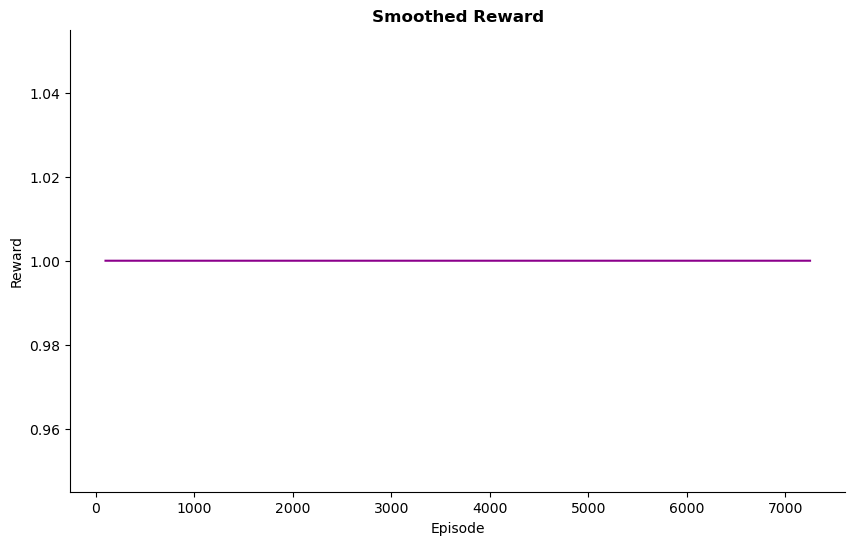

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed Reward', fontweight = 'bold') 
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

----
**Comment:**

Since the task completion reward is set to 1 for success and 0 for failure, the reward graph from the training logs appears as a horizontal line. I as I progress to a more complex environment adding more rewards and penalties, this graph will look different.


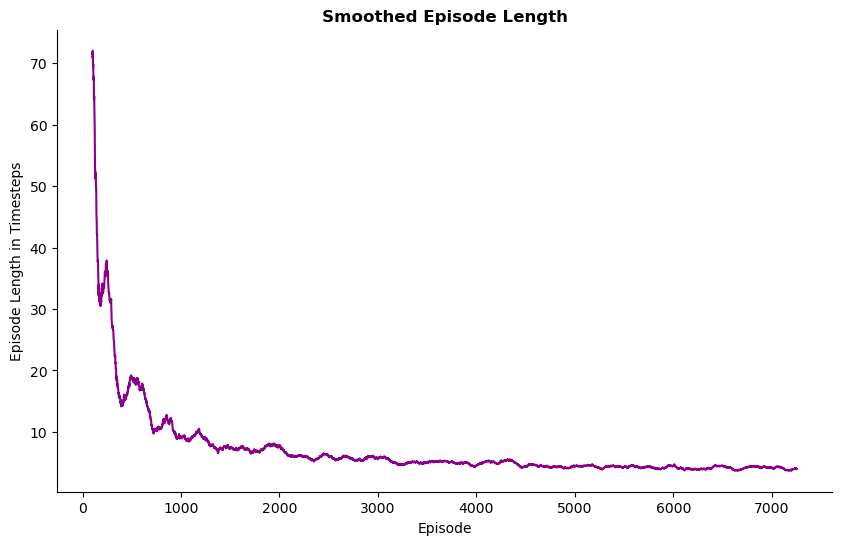

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_length, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Episode Length in Timesteps')
plt.title('Smoothed Episode Length', fontweight = 'bold')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

----
**Comment:**

Early in the training the agent takes a more timesteps to complete the task. This is expected in RL as the agent prioritises exploration during the early stages, trying different actions to better understand its environment. As a result, it requires more timesteps per episode.

As the training progresses, the agent refines its policy and begins to exploit what it has learned, leading to fewer timesteps per episode. The curve begins to plateau around episode 3000, which indicated that the agent’s policy has become more effective in completing the task. This stability in timesteps suggests the agent has learned a near-optimal path.





### Saving the Model

In [15]:
model.save('../../Training/Saved Models/PPO_simple_haunted_mansion')

### Testing after PPO training

In [32]:
gym.register(
    id='Haunted_Mansion-v1',
    entry_point='simple_env:Simple_Haunted_Mansion'  
)

In [33]:
env = gym.make('Haunted_Mansion-v1', render_mode = 'human')

In [34]:
# Setting the number of episodes for testing
episodes = 15

for episode in range(1, episodes + 1):
   
    # Resetting the environment to an initial state
    obs, info_= env.reset()
    done = False
    
    while not done:
        # Get action from the trained model
        action, _ = model.predict(obs) 
        
        # Step through the environment using the action
        obs, reward, terminated,truncated, info = env.step(action)  
               
        # Update the done condition based on terminated flag (truncated is always False in this env)
        done = terminated

        # Visualise the environment after each action agent takes
        env.render()
        
        # Delay to slow down the movement for better observation
        pygame.time.delay(350) 
    
    # After the episode ends, print the score
    print(f'Episode {episode} Score: {reward}')

env.close()


Episode 1 Score: 1
Episode 2 Score: 1
Episode 3 Score: 1
Episode 4 Score: 1
Episode 5 Score: 1
Episode 6 Score: 1
Episode 7 Score: 1
Episode 8 Score: 1
Episode 9 Score: 1
Episode 10 Score: 1
Episode 11 Score: 1
Episode 12 Score: 1
Episode 13 Score: 1
Episode 14 Score: 1
Episode 15 Score: 1


----
**Comment:**

After seeing the agent's actions via pygame, its clear the agent doesn't always take the most optimal path, to get the agent to do this I can add a penalty to the number of timesteps taken to reach the target. This is something I will implement by adding a penalty of 0.1 for every action which did not result in finding the target location.

To do this I will add a else case into the if statement in the step function for reward.



## Evalution
-----

Not much point in running the evaluate_policy since reward system is quite simple. Across all episodes the agent was able to get to the door and receive the reward of 1.

Since there is no penalty there is no real incentive for the agent to learn the most optimal path to the exit door. To add penalty to the reward to force the agent to start finding the optimal path. I will be adding this in in the next iteration of my custom environment. 

## Summary
-------

In this notebook, I have successfully created a simple custom environment for Trick or ReTreat with rendering in pygame. 

After training the agent using PPO, it is clear the agent has learnt to escape the mansion but fails to find the most optimal path. In the next notebook I will be making the following changes to the environment:

    - adding penalty for each timestep the agent does not reach its target(door).
    - adding in ghosts and candies to see if the agent can find an optimal path while maximsing its rewards.
    - implement Q-learning instead of PPO to deal with the added complexity.
    - compare PPO model and Q-learning training to see which trains the agent better.